<a href="https://colab.research.google.com/github/thanhdangg/MRI-Brain-tumor-segmentation/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import something

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nibabel pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.1 MB/s eta 0:00:00


In [ ]:
!pip install tensoflow keras

ERROR: Could not find a version that satisfies the requirement tensoflow (from versions: none)
ERROR: No matching distribution found for tensoflow


In [ ]:
import cv2
import h5py
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
from keras import Input, Model
from keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
)
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
import pydicom

# Datasets

The first folder is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4).
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel.
- The 4th dimension is the values for 4 different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second folder in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

In [ ]:
HOME_DIR = "/content/drive/MyDrive/BraTS_segmentation/Task01_BrainTumour/"
DATA_DIR = HOME_DIR

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def read_and_plot_nifti(file_path):
    try:
        # Load NIfTI file
        nifti_img = nib.load(file_path)

        # Get data and header
        data = nifti_img.get_fdata()
        header = nifti_img.header
        affine = nifti_img.affine

        # Print basic information
        print("Shape of data:", data.shape)
        print("Affine matrix:\n", affine)
        print("Data type:", header.get_data_dtype())
        print("Header information:\n", header)

        # Normalize data to [0, 1] for visualization
        data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)

        # Select middle slices for visualization
        middle_slice = [int(data.shape[i] / 2) for i in range(3)]
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Coronal plane
        axes[0].imshow(data[middle_slice[0], :, :], cmap="gray")
        axes[0].set_title("Coronal Plane")
        axes[0].axis("off")

        # Transversal plane
        axes[1].imshow(data[:, middle_slice[1], :], cmap="gray")
        axes[1].set_title("Transversal Plane")
        axes[1].axis("off")

        # Sagittal plane
        axes[2].imshow(data[:, :, middle_slice[2]], cmap="gray")
        axes[2].set_title("Sagittal Plane")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Error reading or plotting the NIfTI file:", e)


Shape of data: (240, 240, 155, 4)
Affine matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Data type: float32
Header information:
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
qu

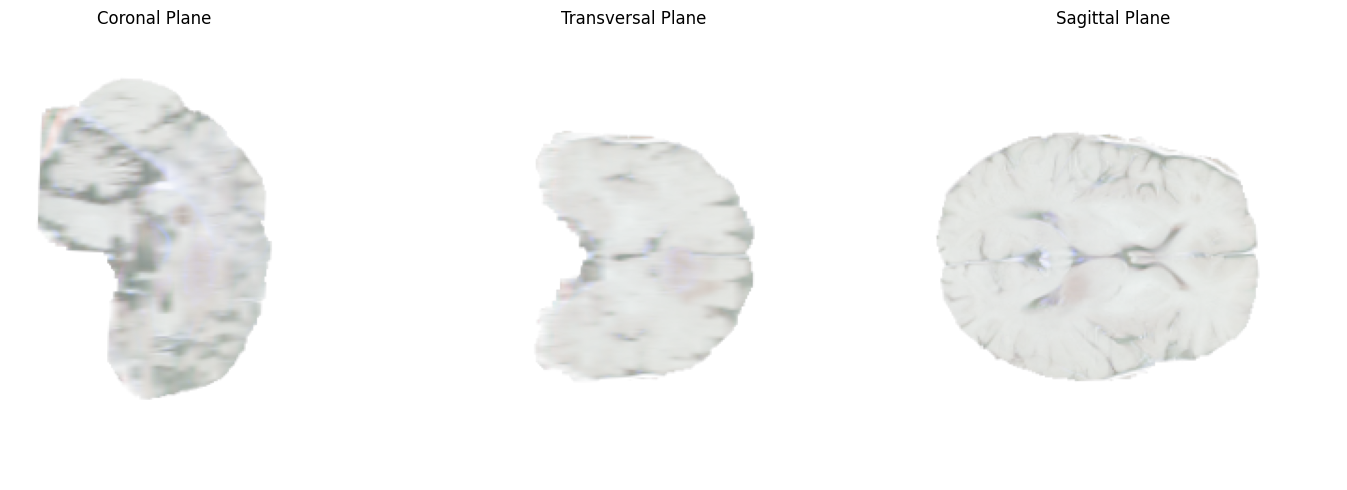

In [ ]:
file_path = DATA_DIR + "imagesTr/BRATS_007.nii.gz"
read_and_plot_nifti(file_path)


In [ ]:
def read_and_plot_nifti_label(file_path):
    try:
        # Load NIfTI file
        nifti_img = nib.load(file_path)

        # Get data and header
        data = nifti_img.get_fdata()
        header = nifti_img.header
        affine = nifti_img.affine

        # Print basic information
        print("Shape of data:", data.shape)
        print("Affine matrix:\n", affine)
        print("Data type:", header.get_data_dtype())
        print("Header information:\n", header)

        # Select middle slices for visualization
        middle_slice = [int(data.shape[i] / 2) for i in range(3)]
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Coronal plane
        axes[0].imshow(data[middle_slice[0], :, :], cmap="tab20")
        axes[0].set_title("Coronal Plane (Label)")
        axes[0].axis("off")

        # Transversal plane
        axes[1].imshow(data[:, middle_slice[1], :], cmap="tab20")
        axes[1].set_title("Transversal Plane (Label)")
        axes[1].axis("off")

        # Sagittal plane
        axes[2].imshow(data[:, :, middle_slice[2]], cmap="tab20")
        axes[2].set_title("Sagittal Plane (Label)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Error reading or plotting the NIfTI file:", e)


In [ ]:
file_path = DATA_DIR + "labelsTr/BRATS_007.nii.gz"
read_and_plot_nifti_label(file_path)


Error reading or plotting the NIfTI file: name 'nib' is not defined


In [ ]:
# load the image and label file, get the image content and return a numpy array for each
def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())

    return image, label

In [ ]:
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

In [ ]:
def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)


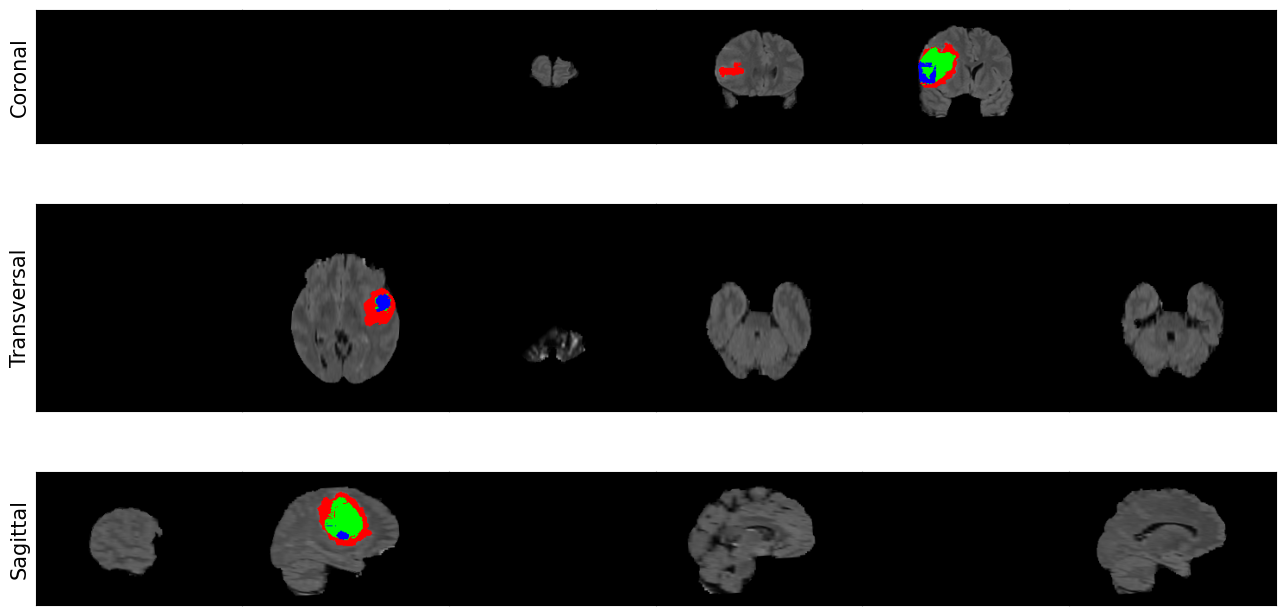

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_004.nii.gz", DATA_DIR + "labelsTr/BRATS_004.nii.gz")
image = get_labeled_image(image, label)
plot_image_grid(image)

In [ ]:
def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')


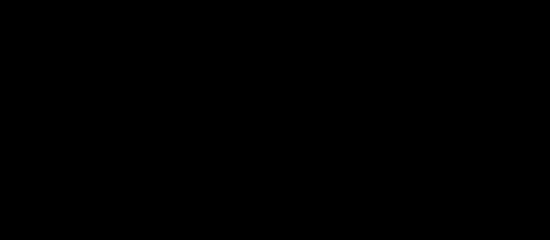

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_007.nii.gz", DATA_DIR + "labelsTr/BRATS_057.nii.gz")
visualize_data_gif(get_labeled_image(image, label))

# Data Preprocessing

## Bias Field Correction (Sửa lỗi từ trường)

---






- Mục tiêu: Điều chỉnh các biến thể về cường độ trong ảnh do sự không đồng nhất của từ trường MRI, giúp cải thiện sự đồng nhất của các giá trị cường độ trong não.
- Cách thực hiện: Sử dụng thuật toán N4ITK (được cung cấp bởi thư viện SimpleITK) để thực hiện bias field correction.

In [ ]:
!pip install SimpleITK


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 8.5 MB/s eta 0:00:00


Thực hiện:
- Tách ảnh 4D thành các chuỗi 3D: Bởi vì mỗi chuỗi (FLAIR, T1w, t1gd, T2w) là một ảnh 3D, cần tách từng chuỗi ra để thực hiện Bias Field Correction.
- Áp dụng Bias Field Correction: Dùng N4BiasFieldCorrectionImageFilter để thực hiện sửa lỗi từ trường cho từng chuỗi 3D riêng biệt.
- Kết hợp các chuỗi lại thành ảnh 4D: Sau khi xử lý mỗi chuỗi, cần ghép các chuỗi lại với nhau để có ảnh 4D đã được sửa lỗi từ trường.

In [ ]:
import SimpleITK as sitk

def bias_field_correction_4d(image_path):
    # Đọc ảnh 4D từ file
    image_4d = sitk.ReadImage(image_path)

    # Tách ảnh 4D thành các chuỗi 3D (mỗi chuỗi là một MRI sequence)
    num_channels = image_4d.GetSize()[3]
    print(f"Num chanel: {num_channels}")
    corrected_images = []

    for c in range(num_channels):
        # Tách chuỗi 3D hiện tại
        print(f"Processing channel {c}")
        image_3d = image_4d[:, :, :, c]

        # Thực hiện Bias Field Correction cho chuỗi 3D
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(image_3d)

        corrected_images.append(corrected_image)

    # Chuyển các chuỗi đã sửa lỗi thành ảnh 4D lại (nếu cần)
    corrected_image_4d = sitk.Compose(corrected_images)

    # Lưu ảnh 4D đã sửa lỗi
    sitk.WriteImage(corrected_image_4d, 'corrected_image_4d.nii.gz')

    return corrected_image_4d



In [ ]:
file_path = DATA_DIR + "imagesTr/BRATS_007.nii.gz"

corrected_image = bias_field_correction_4d(file_path)


Num chanel: 4
Processing channel 0
Processing channel 1
Processing channel 2
Processing channel 3


## Patch Sampling with Tumor Focused Sampling (Lấy mẫu patch tập trung vào khối u)

- Mục tiêu: Thực hiện việc lấy mẫu các patch (sub-volumes) sao cho có ít nhất 5% dữ liệu là khối u, giúp mô hình học được đặc trưng của khối u.
- Cách thực hiện: Lọc ra các patch chứa ít nhất 5% khối u từ các ảnh MRI, đảm bảo rằng mô hình sẽ học được các đặc trưng từ các vùng có khối u thay vì chỉ học các vùng nền (background).

In [ ]:
def get_sub_volume(image, label,
                   orig_x = 240, orig_y = 240, orig_z = 155,
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000,
                   background_threshold=0.95):
    # Initialize features and labels with `None`
    X = None
    y = None


    tries = 0

    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0 , orig_x - output_x + 1)
        start_y = np.random.randint(0 , orig_y - output_y + 1)
        start_z = np.random.randint(0 , orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes = num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:,:,:,0]) / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])

            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X,3,0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y,3,0)

            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]

            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [ ]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)


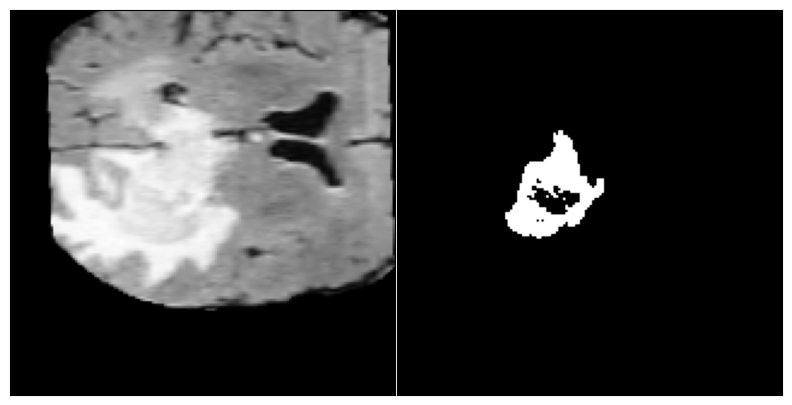

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
visualize_patch(X[0, :, :, :], y[2])

## Intensity Normalization (Chuẩn hóa cường độ)

- Mục tiêu:  chuẩn hóa dữ liệu (standardization) cho từng lát cắt (slice) trong ảnh 4D (4 chiều).

- Cách thực hiện: chuẩn hóa các giá trị trên mỗi kênh và mỗi mặt phẳng Z sao cho có giá trị trung bình bằng 0 và độ lệch chuẩn là 1,

In [ ]:
def standardize(image):

    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)

            # divide by the standard deviation (only if it is different from zero)
            centered_scaled = centered / np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

In [ ]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


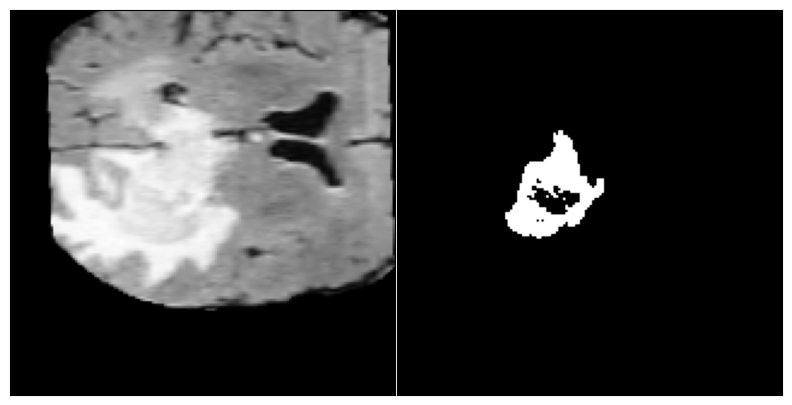

In [ ]:
visualize_patch(X_norm[0, :, :, :], y[2])

## Giảm nhiễu (Noise Reduction)


In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.1 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

In [ ]:
def noise_reduction(image_array):
    """
    Applies anisotropic diffusion filtering to reduce noise in the input 3D image.

    Parameters:
    - image_array: 3D numpy array representing the MRI image (single channel).

    Returns:
    - denoised_image_array: 3D numpy array after noise reduction.
    """
    # Convert numpy array to SimpleITK image
    sitk_image = sitk.GetImageFromArray(image_array)

    # Apply Anisotropic Diffusion Filtering
    denoised_image = sitk.CurvatureAnisotropicDiffusion(
        sitk_image,
        timeStep=0.0625,        # Time step parameter (should be small to ensure stability)
        conductanceParameter=3.0, # Controls edge preservation
        numberOfIterations=10  # Number of iterations for smoothing
    )

    # Convert SimpleITK image back to numpy array
    denoised_image_array = sitk.GetArrayFromImage(denoised_image)

    return denoised_image_array

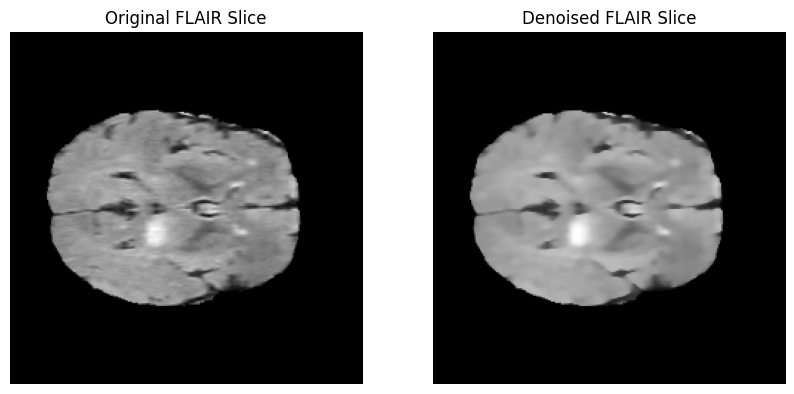

In [ ]:
nifti_image = nib.load(file_path)
image_data = nifti_image.get_fdata()

# Select one channel to denoise, e.g., FLAIR
flair_image = image_data[..., 0]  # Assuming the first channel is FLAIR

# Apply noise reduction
denoised_flair = noise_reduction(flair_image)

# Visualize original and denoised images
slice_idx = flair_image.shape[2] // 2  # Middle slice in Z-dimension
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(flair_image[:, :, slice_idx], cmap="gray")
axes[0].set_title("Original FLAIR Slice")
axes[0].axis("off")

axes[1].imshow(denoised_flair[:, :, slice_idx], cmap="gray")
axes[1].set_title("Denoised FLAIR Slice")
axes[1].axis("off")

plt.show()

In [ ]:
def noise_reduction_all_channels(image_array):
    """
    Applies anisotropic diffusion filtering to reduce noise in all channels of a 4D image.

    Parameters:
    - image_array: 4D numpy array (e.g., [240, 240, 155, 4]).

    Returns:
    - denoised_image_array: 4D numpy array after noise reduction.
    """
    denoised_image_array = np.zeros(image_array.shape)

    for c in range(image_array.shape[3]):  # Iterate through each channel
        denoised_image_array[..., c] = noise_reduction(image_array[..., c])

    return denoised_image_array

## Data Agumentation

In [ ]:
import random
from scipy.ndimage import rotate


In [ ]:
def random_rotation(image, angle_range=(0, 360)):
    """
    Randomly rotate the image around the Z-axis.

    Parameters:
    - image: 3D numpy array (e.g., [240, 240, 155]).
    - angle_range: Tuple specifying the range of rotation angles.

    Returns:
    - Rotated 3D image.
    """
    angle = random.uniform(*angle_range)
    rotated_image = rotate(image, angle, axes=(1, 0), reshape=False, mode='nearest')
    return rotated_image

In [ ]:
def random_flip(image):
    """
    Randomly flip the image along axes.

    Parameters:
    - image: 3D numpy array (e.g., [240, 240, 155]).

    Returns:
    - Flipped 3D image.
    """
    if random.choice([True, False]):
        image = np.flip(image, axis=0)  # Flip along X-axis
    if random.choice([True, False]):
        image = np.flip(image, axis=1)  # Flip along Y-axis
    return image


Elastic Deformation: Biến dạng đàn hồi được thực hiện bằng cách áp dụng biến dạng ngẫu nhiên lên lưới tọa độ.

In [ ]:
from scipy.ndimage import map_coordinates, gaussian_filter

def elastic_deformation(image, alpha, sigma):
    """
    Apply elastic deformation to the image.

    Parameters:
    - image: 3D numpy array.
    - alpha: Scaling factor for deformation intensity.
    - sigma: Standard deviation for Gaussian filter.

    Returns:
    - Deformed 3D image.
    """
    shape = image.shape
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing="ij")
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))

    deformed_image = map_coordinates(image, indices, order=1, mode="reflect").reshape(shape)
    return deformed_image


In [ ]:
from scipy.ndimage import zoom

def random_scaling(image, scale_range=(0.9, 1.1)):
    """
    Apply random scaling to the image.

    Parameters:
    - image: 3D numpy array.
    - scale_range: Tuple specifying min and max scaling factors.

    Returns:
    - Scaled 3D image.
    """
    scale = random.uniform(*scale_range)
    scaled_image = zoom(image, (scale, scale, scale), mode='nearest')

    # Crop or pad back to original size
    target_shape = image.shape
    output_image = np.zeros(target_shape)
    min_shape = np.minimum(scaled_image.shape, target_shape)

    output_image[:min_shape[0], :min_shape[1], :min_shape[2]] = scaled_image[:min_shape[0], :min_shape[1], :min_shape[2]]
    return output_image


In [ ]:
def random_intensity_shift(image, shift_range=(-0.1, 0.1)):
    """
    Apply random intensity shift to the image.

    Parameters:
    - image: 3D numpy array.
    - shift_range: Tuple specifying min and max shift values.

    Returns:
    - Intensity-shifted 3D image.
    """
    shift = random.uniform(*shift_range)
    shifted_image = image + shift
    shifted_image = np.clip(shifted_image, 0, 1)  # Ensure pixel values stay in [0, 1]
    return shifted_image


In [ ]:
def augment_image(image):
    """
    Apply a series of random augmentations to the input image.

    Parameters:
    - image: 3D numpy array.

    Returns:
    - Augmented 3D image.
    """
    image = random_rotation(image)
    image = random_flip(image)
    image = elastic_deformation(image, alpha=1, sigma=5)
    image = random_scaling(image)
    image = random_intensity_shift(image)
    return image


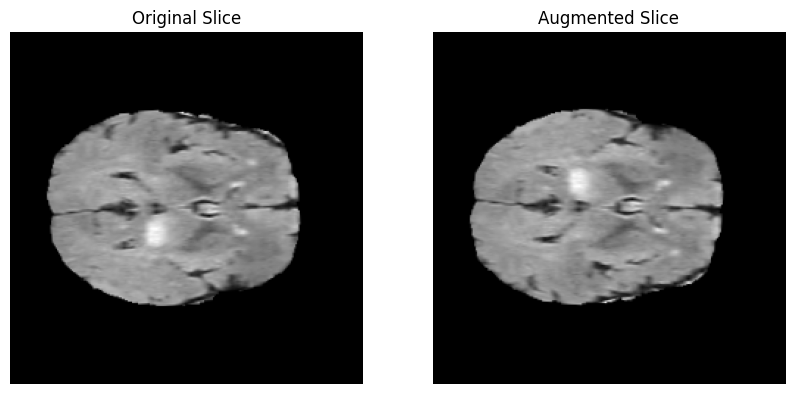

In [ ]:
nifti_image = nib.load(file_path)
image_data = nifti_image.get_fdata()

# Apply augmentation
flair_image = image_data[..., 0]  # Select one channel
augmented_image = augment_image(flair_image)

# Visualize original and augmented slices
slice_idx = flair_image.shape[2] // 2  # Middle slice
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(flair_image[:, :, slice_idx], cmap="gray")
axes[0].set_title("Original Slice")
axes[0].axis("off")

axes[1].imshow(augmented_image[:, :, slice_idx], cmap="gray")
axes[1].set_title("Augmented Slice")
axes[1].axis("off")

plt.show()

# Metrics

## Dice Similarity Coefficient



Aside from the architecture, one of the most important elements of any deep learning method is the choice of our loss function.

A natural choice that you may be familiar with is the cross-entropy loss function.
- However, this loss function is not ideal for segmentation tasks due to heavy class imbalance (there are typically not many positive regions).

A much more common loss for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap.
- The Dice index ranges from 0 (complete mismatch)
- To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as:
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth.

Our model will map each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

The dice coefficient "DSC" is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">


Implement the dice coefficient for a single output class below.


In [ ]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2),
                                  epsilon=0.00001):
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2 * np.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) + epsilon
    dice_coefficient = dice_numerator / dice_denominator

    ### END CODE HERE ###

    return dice_coefficient

## Soft Dice Loss


While the Dice Coefficient makes intuitive sense, it is not the best for training.
- This is because it takes in discrete values (zeros and ones).
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs.

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth
- In practice each $q_i$ will either be 0 or 1.
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

You can also check that if $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.


### Multi-Class Soft Dice Loss

We've explained the single class case for simplicity, but the multi-class generalization is exactly the same as that of the dice coefficient.
- Since you've already implemented the multi-class dice coefficient, we'll have you jump directly to the multi-class soft dice loss.

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3),
                   epsilon=0.00001):
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2 * tf.reduce_sum(y_true * y_pred , axis= axis) + epsilon
    dice_denominator = tf.reduce_sum(y_true ** 2, axis= axis) + tf.reduce_sum(y_pred ** 2 , axis = axis) + epsilon
    dice_loss = 1 - tf.reduce_mean(dice_numerator / dice_denominator)

    ### END CODE HERE ###

    return dice_loss

# Define model
